<hr style="border-top-width:4px; border-top-color: #00df;">

# Analysis of Covid-19 papers

* Emerson Rodrigues Vero filho
* Mojtaba Roshana
* Luca Giorgetti
* Roya Joulaei

<hr style="border-top-width:4px; border-top-color: #00df;">


# Introduction
This distributed computing project will be focused on the analysis of 1000 papers about COVID-19, SARS-CoV-2, and related coronaviruses. The dataset is a sub-sample of 1000 items taken from the original dataset that is composed of more than 75000 (and still growing) papers. This dataset is a part of real-world research on COVID-19 named COVID-19 Open Research Dataset Challenge (CORD-19). The research and related chal- lenges are available on the dedicated page on Kaggle: https://www.kaggle.com/allen- institute-for-ai/CORD-19-research-challenge


In [2]:
import json
import time
import csv
from dask.distributed import Client, SSHCluster
from dask import delayed
import dask.bag as db
import dask.dataframe as ddf
import functools
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
from collections import Counter
from operator import add
from operator import itemgetter
import matplotlib.pyplot as plt
from operator import itemgetter


* There are three vitual machines: 

In [3]:
machine1 = '10.67.22.93'
machine2 = '10.67.22.77'
machine3 = '10.67.22.134'

* Define the Client with SSHCluster:

In [4]:
cluster = SSHCluster([machine2, machine1, machine3])
client = Client(cluster)


2022-07-11 21:03:55,699 - distributed.deploy.ssh - INFO - /usr/local/lib/python3.8/dist-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
2022-07-11 21:03:55,702 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2022-07-11 21:03:55,703 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 46027 instead
2022-07-11 21:03:55,704 - distributed.deploy.ssh - INFO - warnings.warn(
2022-07-11 21:03:55,705 - distributed.deploy.ssh - INFO - 2022-07-11 21:03:55,697 - distributed.scheduler - INFO - State start
2022-07-11 21:03:55,708 - distributed.deploy.ssh - INFO - 2022-07-11 21:03:55,702 - distributed.scheduler - INFO - Clear task state
2022-07-11 21:03:55,709 - distributed.deploy.ssh - INFO - 2022-07-11 21:03:55,705 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.77:38631
2022-07-11 21:03:57,335 - distributed.deploy.ssh - INFO - 2022-07-11 21:03:57,329 - distributed.nanny - INFO -         Start Nanny at: 'tcp:/

* Machine2 is the sceduler and Machine1, Machine3 are the workers
* We have 15.54 GiB RAM total memory

In [5]:
client

<Client: 'tcp://10.67.22.77:38631' processes=1 threads=4, memory=7.77 GiB>

# Loading the data  

We make a 200Gib volume and download the data inside. From that we extract 1000 papers and put them inside a 30 Gib volume. The latter is then shared between the scheduler and the workers.

Our RAW data are in json format multiple line, therefore we convert them to single line json to make it readable:

In [6]:
'''
def one_lined(filename):
    f = open(filename)
    obj = json.load(f)
    flatten_str = json.dumps(obj)  #this coommaand convert a dictionary into a string
    jsonFile=open("./new/"+"new_"+filename,"w")
    jsonFile.write(flatten_str)
    jsonFile.close
#l=os.listdir('/mnt/nfs_share/test')
#cd /mnt/nfs_share/test

for i in l:
    if (i != 'new'):
        print(i)
        f = open(i)
        obj = json.load(f)
        flatten_str = json.dumps(obj)
        jsonFile=open("./new/"+"new_"+i,"w")
        jsonFile.write(flatten_str)
        jsonFile.close
'''

'\ndef one_lined(filename):\n    f = open(filename)\n    obj = json.load(f)\n    flatten_str = json.dumps(obj)  #this coommaand convert a dictionary into a string\n    jsonFile=open("./new/"+"new_"+filename,"w")\n    jsonFile.write(flatten_str)\n    jsonFile.close\n#l=os.listdir(\'/mnt/nfs_share/test\')\n#cd /mnt/nfs_share/test\n\nfor i in l:\n    if (i != \'new\'):\n        print(i)\n        f = open(i)\n        obj = json.load(f)\n        flatten_str = json.dumps(obj)\n        jsonFile=open("./new/"+"new_"+i,"w")\n        jsonFile.write(flatten_str)\n        jsonFile.close\n'

We take all the single-line json files inside a bag (lines)

In [7]:
filename = '/mnt/nfs_share/test/new/*.json'
bag = db.read_text(filename)
js = bag.map(json.loads).repartition(3)                        

But we need only the body text part:

In [8]:
js.pluck("body_text").take(1)

([{'text': 'SARS-CoV-2 pneumonia manifests as acute respiratory failure, which most often requires oxygen supplementation. In severely affected patients, the need for oxygen is sometimes so great that it can lead to invasive mechanical ventilation, a procedure that is associated with a high mortality rate. [1] At the beginning of the pandemic, the indications for intubation of patients with COVID-19 were broad. [1] However, as more experience was gained, practitioners began to use high-flow nasal oxygen therapy as an alternative to too early intubation. This method provides humidified and heated oxygen with a FiO2 of up to 100% and a flow rate of up to 80L/min. This would decrease the work of breathing, decrease dead space, improve mucociliary clearance and give a PEEP effect of 2 to 7 mmHg. [2] This technique of high flow nasal oxygen therapy was at the beginning of the pandemic limited to a flow of 30L/min [3] because the learned societies feared a high contamination of the nursing s

# 1.Word counter distributed algorithm:




## Map phase

For each document 'Di', we produce a set of intermediate pairs (w, cp(w)), one for each word w ∈ Di, in which cp(w) is the number of occurrences of w in Di. E.g.: (′hello′,3)

We collect the text part ("body_text") of papers and merge them togethere

In [9]:
def merge_json(data):
    all_text=''
    for t in data:
        all_text+=t['text'] # only text part of budy text
    return all_text

texts = js.pluck("body_text").map(merge_json) # the bag with only text part of data
texts.take(1)


("SARS-CoV-2 pneumonia manifests as acute respiratory failure, which most often requires oxygen supplementation. In severely affected patients, the need for oxygen is sometimes so great that it can lead to invasive mechanical ventilation, a procedure that is associated with a high mortality rate. [1] At the beginning of the pandemic, the indications for intubation of patients with COVID-19 were broad. [1] However, as more experience was gained, practitioners began to use high-flow nasal oxygen therapy as an alternative to too early intubation. This method provides humidified and heated oxygen with a FiO2 of up to 100% and a flow rate of up to 80L/min. This would decrease the work of breathing, decrease dead space, improve mucociliary clearance and give a PEEP effect of 2 to 7 mmHg. [2] This technique of high flow nasal oxygen therapy was at the beginning of the pandemic limited to a flow of 30L/min [3] because the learned societies feared a high contamination of the nursing staff throu

* We split the words
* remove the stop words which does not add any meaning ( i.e have,has,is,or,and )


In [10]:
#s=time.time()
def cleaner(text):

    stop_words = stopwords.words('english')
    text_tokens=word_tokenize(text)

    tokens_without_sw=[word.lower() for word in text_tokens if not word.lower() in stop_words and word.isalpha()]
    return tokens_without_sw

text_clean = texts.map(cleaner)
text_clean.take(1)[0][:15]
#e=time.time()
#e-s
#3 sex

['pneumonia',
 'manifests',
 'acute',
 'respiratory',
 'failure',
 'often',
 'requires',
 'oxygen',
 'supplementation',
 'severely',
 'affected',
 'patients',
 'need',
 'oxygen',
 'sometimes']

Count each unique word and its frequency

In [11]:
# convert list to list of directories
# where the unique words and their frequency is stored

def count(text):
    counts = dict(zip(Counter(text).keys(), Counter(text).values()))
    words_counted = [{"word":x , "frequency": y} for x,y in counts.items()]
    return words_counted

words = text_clean.map(count)
words.take(1)

([{'word': 'pneumonia', 'frequency': 2},
  {'word': 'manifests', 'frequency': 1},
  {'word': 'acute', 'frequency': 4},
  {'word': 'respiratory', 'frequency': 5},
  {'word': 'failure', 'frequency': 4},
  {'word': 'often', 'frequency': 1},
  {'word': 'requires', 'frequency': 1},
  {'word': 'oxygen', 'frequency': 17},
  {'word': 'supplementation', 'frequency': 2},
  {'word': 'severely', 'frequency': 1},
  {'word': 'affected', 'frequency': 1},
  {'word': 'patients', 'frequency': 23},
  {'word': 'need', 'frequency': 1},
  {'word': 'sometimes', 'frequency': 1},
  {'word': 'great', 'frequency': 1},
  {'word': 'lead', 'frequency': 1},
  {'word': 'invasive', 'frequency': 3},
  {'word': 'mechanical', 'frequency': 7},
  {'word': 'ventilation', 'frequency': 10},
  {'word': 'procedure', 'frequency': 1},
  {'word': 'associated', 'frequency': 2},
  {'word': 'high', 'frequency': 8},
  {'word': 'mortality', 'frequency': 6},
  {'word': 'rate', 'frequency': 6},
  {'word': 'beginning', 'frequency': 2},
  

## Reduce phase

* For each word w, gather all the previous pairs (w, cp(w)) and return the final pair (w,c(w)) where c(w) is the number of occurrences of w for all the Documents.


In [12]:
def sumation(total, x):
    return total+x['frequency']

# using flatten to un-fold the dictionary into a list-like object
# using foldby to sum all unique words 

All_counts = words.flatten().foldby('word', binop=sumation,initial=0,combine=add,combine_initial=0).compute()

In [13]:
# sorting
All_counts_sorted = sorted(All_counts, key=itemgetter(1), reverse=True)
All_counts_sorted[:10]

[('patients', 10046),
 ('et', 9532),
 ('study', 9386),
 ('data', 8821),
 ('also', 8188),
 ('may', 6599),
 ('using', 6307),
 ('used', 6175),
 ('health', 6062),
 ('cells', 5633)]

In [14]:
#All_counts_sorted=All_counts_sorted.pop(1)
#del All_counts_sorted[7]
#All_counts_sorted

Let's plot for most repeated words in papers

In [15]:
freq = [All_counts_sorted[i][1] for i in range(0,len(All_counts_sorted))]
word = [All_counts_sorted[i][0] for i in range(0,len(All_counts_sorted))]

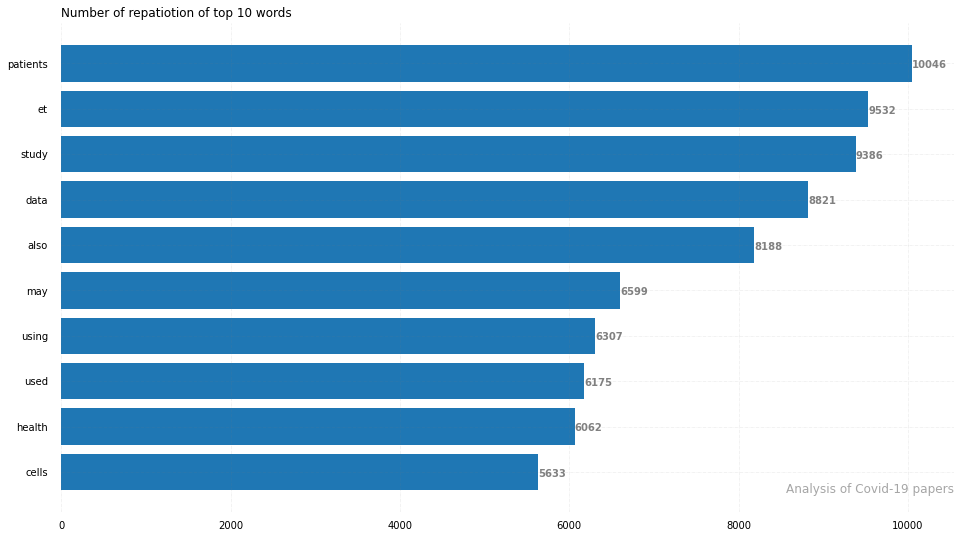

In [16]:
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(word[:10], freq[:10])
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
            str(round((i.get_width()), 2)),
            fontsize = 10, fontweight ='bold',
            color ='gray')
ax.set_title('Number of repatiotion of top 10 words',
            loc ='left', )
fig.text(0.9, 0.15, 'Analysis of Covid-19 papers', fontsize = 12,
        color ='grey', ha ='right', va ='bottom',
        alpha = 0.7)
plt.show()

## 2.Which are the worst and best-represented countries in the research?
In this part, you have to take the documents and convert them into a usable DataFrame data structure to figure out the countries that are most and less active in the research. To do this you can use the country of the authors. Do the same for the universities (affiliations).
Even in this case do multiple runs by changing the number of partitions and workers and then describe the behavior of the timings.


In [17]:
#let's create the function to extract the needed features
def feat(record):
    name=surname=university=country=''
    
    name = record['first']
    surname = record['last']
    
    if record['affiliation'] == {}:
        university = 'Not given'
        country = 'Not given'
    
    else: #affiliation not void
        if 'institution' in record['affiliation'].keys() and record['affiliation']['institution'] != '': university = record['affiliation']['institution']
        else: university = 'Not given'
        
    if 'location' in record['affiliation'].keys() and 'country' in record['affiliation']['location'].keys() and record['affiliation']['location']['country'] != '':
        country = record['affiliation']['location']['country']
    else: country = 'Not given'
    
    #country='gatto'
    return {
        'name':       name,
        'surname':    surname, 
        'university': university,
        'country':    country,
    }
        
       

In [18]:
authors = js.pluck('metadata').pluck('authors').flatten()
authors_DataFrame = authors.map(feat).to_dataframe()
authors_DataFrame.head()

,name,surname,university,country
0,Rajae,Alkouh,Not given,Not given
1,Abdelilah,Rhalete,VI University Hospital,Morocco
2,Merbouh,Manal,VI University Hospital,Morocco
3,Aidouni,Ghizlane,Not given,Not given
4,Berrichi,Samia,VI University Hospital,Morocco


In [19]:
authors_DataFrame.university.value_counts().head(2) #from here it is possible to make an histogram
authors.take(2)

({'first': 'Rajae',
  'middle': [],
  'last': 'Alkouh',
  'suffix': '',
  'affiliation': {},
  'email': 'alkouhrajae1993@gmail.com'},
 {'first': 'Abdelilah',
  'middle': ['El'],
  'last': 'Rhalete',
  'suffix': '',
  'affiliation': {'laboratory': '',
   'institution': 'VI University Hospital',
   'location': {'settlement': 'Oujda',
    'region': 'Mohammed',
    'country': 'Morocco'}},
  'email': 'elrhaleteabdelilah@yahoo.fr'})

In [20]:
countries = authors_DataFrame.country.value_counts()

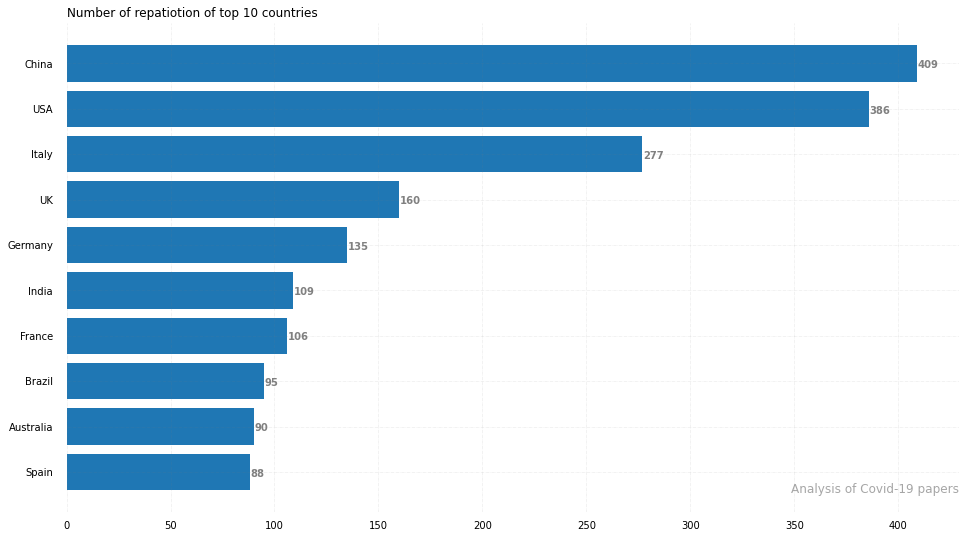

In [21]:
n=10
data = countries.nlargest(n+1).compute()
data = data[data.axes[0]!='Not given']
height = [data[i] for i in range(0,n)]
bars = [data.axes[0][i] for i in range(0,n)]

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(bars[:10], height[:10])
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
            str(round((i.get_width()), 2)),
            fontsize = 10, fontweight ='bold',
            color ='gray')
ax.set_title('Number of repatiotion of top 10 countries',
            loc ='left', )
fig.text(0.9, 0.15, 'Analysis of Covid-19 papers', fontsize = 12,
        color ='grey', ha ='right', va ='bottom',
        alpha = 0.7)
plt.show()

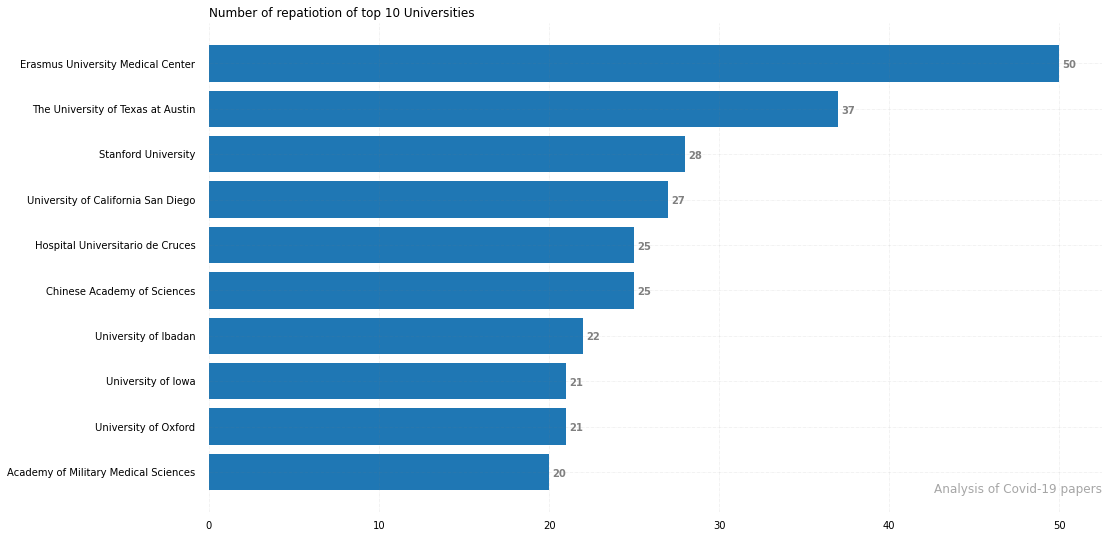

In [22]:
univs = authors_DataFrame.university.value_counts()

n=10
data = univs.nlargest(n+1).compute()
data = data[data.axes[0]!='Not given']
height = [data[i] for i in range(0,n)]
bars = [data.axes[0][i] for i in range(0,n)]

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(bars[:10], height[:10])
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
ax.invert_yaxis()
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
            str(round((i.get_width()), 2)),
            fontsize = 10, fontweight ='bold',
            color ='gray')
ax.set_title('Number of repatiotion of top 10 Universities',
            loc ='left', )
fig.text(0.9, 0.15, 'Analysis of Covid-19 papers', fontsize = 12,
        color ='grey', ha ='right', va ='bottom',
        alpha = 0.7)
plt.show()

 # Chek computation time with different partitions


 Even in this case do multiple runs by changing the number of partitions and workers and then describe the behavior of the timings.

* ## With two workers:

In [23]:
def timing_part1(partitions):

    i = time.time() 
    filename = '/mnt/nfs_share/test/new/*.json'
    bag = db.read_text(filename)

    #process
    All_counts = (bag.map(json.loads).repartition(partitions).pluck('body_text').map(merge_json).map(cleaner)
                  .map(count).flatten().foldby('word', binop=sumation, initial=0, combine=add, combine_initial=0)
                  .compute())
    All_counts_sorted = sorted(All_counts, key=itemgetter(1), reverse=True)
    
    f = time.time()
    
    
    return (f-i)

In [24]:
partitions=[1,2,4,8,12]
for i in partitions:
    print('for partitions=',i,'timing is :', timing_part1(i))

for partitions= 1 timing is : 41.509347677230835
for partitions= 2 timing is : 43.317606687545776
for partitions= 4 timing is : 42.59429478645325
for partitions= 8 timing is : 37.926928758621216
for partitions= 12 timing is : 40.98083186149597


Text(0.5, 1.0, 'With two Worker for computuing most words used in papers')

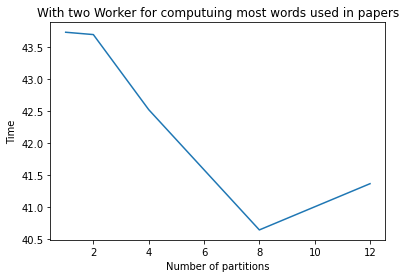

In [25]:
partitions=[1,2,4,8,12]
ts=[43.731369972229004,43.6949143409729,42.523178577423096,40.644028186798096,41.36608290672302]
plt.plot(partitions,ts)
plt.xlabel('Number of partitions')
plt.ylabel('Time')
plt.title('With two Worker for computing most words used in papers')

In [26]:
# timing for part 2
def timing_countries(partitions):
    i = time.time() #start taking time
    auth_df = (bag.map(json.loads).repartition(partitions)
               .pluck('metadata').pluck('authors').flatten().map(feat).to_dataframe())
    countries = authors_DataFrame.country.value_counts().nlargest(10).compute()
    f = time.time()
    return f-i

In [27]:
partitions=[1,2,4,8,12,16]
for i in partitions:
    print('for partitions=',i,'timing is :', timing_countries(i))

for partitions= 1 timing is : 19.746373414993286
for partitions= 2 timing is : 15.172312498092651
for partitions= 4 timing is : 12.607531785964966
for partitions= 8 timing is : 11.480939149856567
for partitions= 12 timing is : 10.883044242858887
for partitions= 16 timing is : 11.140028953552246


* ## Reduce workers to only one worker:

In [28]:
client.close() #close client
cluster.close() #close cluster

In [29]:
cluster = SSHCluster([machine2, machine1])
client = Client(cluster)

2022-07-11 21:10:36,852 - distributed.deploy.ssh - INFO - /usr/local/lib/python3.8/dist-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
2022-07-11 21:10:36,855 - distributed.deploy.ssh - INFO - Perhaps you already have a cluster running?
2022-07-11 21:10:36,858 - distributed.deploy.ssh - INFO - Hosting the HTTP server on port 34957 instead
2022-07-11 21:10:36,859 - distributed.deploy.ssh - INFO - warnings.warn(
2022-07-11 21:10:36,860 - distributed.deploy.ssh - INFO - 2022-07-11 21:10:36,850 - distributed.scheduler - INFO - State start
2022-07-11 21:10:36,863 - distributed.deploy.ssh - INFO - 2022-07-11 21:10:36,855 - distributed.scheduler - INFO - Clear task state
2022-07-11 21:10:36,864 - distributed.deploy.ssh - INFO - 2022-07-11 21:10:36,855 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.77:34165
2022-07-11 21:10:39,016 - distributed.deploy.ssh - INFO - 2022-07-11 21:10:39,013 - distributed.nanny - INFO -         Start Nanny at: 'tcp:/

In [30]:
client

<Client: 'tcp://10.67.22.77:34165' processes=0 threads=0, memory=0 B>

In [31]:
partitions=[1,2,4,8,12,16]
for i in partitions:
    print('for partitions=',i,'timing is :', timing_countries(i))

for partitions= 1 timing is : 34.20174717903137
for partitions= 2 timing is : 26.262715101242065
for partitions= 4 timing is : 22.0327308177948
for partitions= 8 timing is : 19.737826347351074
for partitions= 12 timing is : 19.298277616500854
for partitions= 16 timing is : 18.95794177055359


Text(0.5, 1.0, 'Computing most countries')

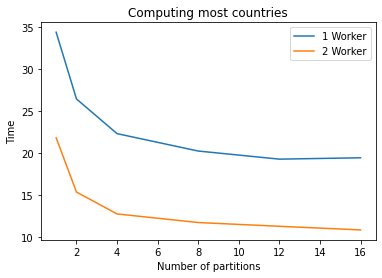

In [32]:
tsc=[21.809123992919922,15.338640451431274,12.722925662994385,11.696454763412476,11.248386859893799,10.814738750457764]
tss=[34.420822620391846,26.454702138900757,22.312560319900513,20.23440670967102,19.26630735397339,19.428391218185425]
plt.plot(partitions,tss,label='1 Worker')
plt.xlabel('Number of partitions')
plt.ylabel('Time')
plt.plot(partitions,tsc,label='2 Worker')
plt.legend()
plt.title('Computing most countries')

# 3. Get the embedding for the title of the papers

In NLP a common technique for performing analysis over a set of texts is to transform the text into a set of vectors each one representing a word inside a document. At the end of the pre-processing the document will be transformed into a list of vectors or a matrix of n × m where n is the number of words in the document and m is the size of the vector that represents the word n.

We load the model as a Dask DataFrame:

In [33]:
model = ddf.read_table('/mnt/nfs_share/wiki.en.vec',
                      quoting=csv.QUOTE_NONE,
                      skiprows=1,
                      header=None, 
                      sep=' ',
                      blocksize='10MB')

In [34]:
model.head(3)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,300,301
0,",",-0.023167,-0.004248,-0.105720,0.042783,-0.143160,-0.078954,0.078187,-0.194540,0.022303,...,-0.11558,0.044184,-0.023124,0.025860,-0.116530,0.010936,0.089398,-0.01590,0.148660,NaN
1,.,-0.111120,-0.001386,-0.177800,0.064508,-0.240370,0.031087,-0.030144,-0.368830,-0.043855,...,-0.21914,-0.042760,-0.136850,0.097470,-0.218180,-0.058233,0.063374,-0.12161,0.039339,NaN
2,the,-0.065334,-0.093031,-0.017571,0.200070,0.029521,-0.039920,-0.163280,-0.072946,0.089604,...,-0.21673,-0.037683,0.081860,-0.039891,-0.051334,-0.101650,0.166420,-0.13079,0.035397,NaN


We make a new DataFrame with PaperIDs and titles: 

In [35]:
def extract_id_title(record):
    ID = record['paper_id']
    title_tokens = word_tokenize(record['metadata']['title'])
    title = [word.lower() for word in title_tokens] 
    return{'ID': ID,
          'title': title}

In [36]:
titles = js.map(extract_id_title)

In [37]:
title_df = titles.to_dataframe()
title_df.head(4)

,ID,title
0,0021ebe4404bb7aea40f696a8261b6bd1d4a7f6b,"[journal, pre-proof, high-flow, nasal, oxygen,..."
1,009b5163b1d8dc61b76f424203ecdc3885234ada,"[high, level, expression, of, surface, glycopr..."
2,00a407540a8bdd6d7425bd8a561eb21d69682511,"[title, :, rapid, ai, development, cycle, for,..."
3,00de40db0c80064b049e3b90d4a6710bb2dfcbc8,"[modelling, the, covid-19, pandemic, in, conte..."


The 'model' DataFrame has too many lines. We want to filter it in order to keep only the words that make up the title of the papers: we can use the above defined functions to find the unique words inside the titles.

In [40]:
title_count = titles.pluck('title').map(count).flatten().foldby('word', binop=sumation,initial=0,combine=add,combine_initial=0).compute()
unique_words_title = [title_count[i][0] for i in range(0,len(title_count))]

In [41]:
mask = model[0].isin(unique_words_title)
filtered_model = model[mask]

In [42]:
filtered_model.head(3) 

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,300,301
0,",",-0.023167,-0.004248,-0.105720,0.042783,-0.143160,-0.078954,0.078187,-0.194540,0.022303,...,-0.11558,0.044184,-0.023124,0.025860,-0.116530,0.010936,0.089398,-0.01590,0.148660,NaN
1,.,-0.111120,-0.001386,-0.177800,0.064508,-0.240370,0.031087,-0.030144,-0.368830,-0.043855,...,-0.21914,-0.042760,-0.136850,0.097470,-0.218180,-0.058233,0.063374,-0.12161,0.039339,NaN
2,the,-0.065334,-0.093031,-0.017571,0.200070,0.029521,-0.039920,-0.163280,-0.072946,0.089604,...,-0.21673,-0.037683,0.081860,-0.039891,-0.051334,-0.101650,0.166420,-0.13079,0.035397,NaN


To move forward, we need to create another dataframe containing the paper IDs and the embedded representation of the titles.
Unfortunatelly, we did not manage to do that, yet. Very likely, the problem is in the 'for' loop inside the 'cfr_title_model' function, that needs to be parallelized.

In [ ]:
'''#this does not work: too slow
def cfr_title_model(record):
    embeddings = {}
    word_title_list = record['title']
    ID = record['ID']

    for word in word_title_list:
        embeddings[word]=filtered_model[filtered_model[0] == word]
    
    return{'ID':ID,
          'embeddings':embeddings}
'''

In [ ]:
#dp=titles.map(cfr_title_model)

In [ ]:
#dataframe_dp = dp.to_dataframe()